<a href="https://colab.research.google.com/github/mayankmjk/DL_LAb/blob/main/Experiment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Generation using RNN (Poems-100)

Experiment: Compare **One-Hot Encoding** vs **Trainable Word Embeddings** for next-word prediction.

# **1. Setup & Dataset Loading**

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
import time
import random

In [2]:
# Load dataset
import os
CSV_PATH = "poems-100 - poems-100.csv"
if not os.path.exists(CSV_PATH):
    CSV_PATH = "/content/poems-100 - poems-100.csv"

df = pd.read_csv(CSV_PATH)
texts = df.iloc[:, 0].dropna().tolist()

print("Total poems:", len(texts))
print("\nSample poem (first 300 chars):\n", (texts[0] if texts else "")[:300])

Total poems: 100

Sample poem (first 300 chars):
 O my Luve's like a red, red rose
That’s newly sprung in June;
O my Luve's like the melodie
That’s sweetly play'd in tune.

As fair art thou, my bonnie lass,
So deep in luve am I:
And I will luve thee still, my dear,
Till a’ the seas gang dry:

Till a’ the seas gang dry, my dear,
And the rocks melt w


In [3]:
def tokenize_text(texts):
    words = []
    for line in texts:
        words.extend(line.lower().split())
    return words

tokens = tokenize_text(texts)

vocab = sorted(set(tokens))
word_to_idx = {w: i for i, w in enumerate(vocab)}
idx_to_word = {i: w for w, i in word_to_idx.items()}
vocab_size = len(vocab)

print("Vocabulary size:", vocab_size)

Vocabulary size: 6989


# **RNN From Scratch (NumPy)**

In [4]:
class RNN_Numpy:
    def __init__(self, vocab_size, hidden_size):
        self.hidden_size = hidden_size
        self.Wxh = np.random.randn(hidden_size, vocab_size) * 0.01
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Why = np.random.randn(vocab_size, hidden_size) * 0.01
        self.h = np.zeros((hidden_size, 1))

    def forward(self, x):
        self.h = np.tanh(self.Wxh @ x + self.Whh @ self.h)
        y = self.Why @ self.h
        return y

hidden_size = 50
rnn = RNN_Numpy(vocab_size, hidden_size)

In [5]:
# Test RNN with one word
x = np.zeros((vocab_size, 1))
x[word_to_idx.get(tokens[0], 0)] = 1

output = rnn.forward(x)
print("Output shape:", output.shape)

Output shape: (6989, 1)


# **Part 2: One-Hot Encoding with PyTorch**

## **2.1 Creating Sequences**

In [6]:
def create_sequences(tokens, seq_len=5):
    sequences = []
    targets = []
    for i in range(len(tokens) - seq_len):
        seq = tokens[i:i+seq_len]
        target = tokens[i+seq_len]
        sequences.append([word_to_idx.get(w, 0) for w in seq])
        targets.append(word_to_idx.get(target, 0))
    return sequences, targets

seq_len = 5
X, y = create_sequences(tokens, seq_len)

X = torch.tensor(X)
y = torch.tensor(y)

print("Input shape:", X.shape)

Input shape: torch.Size([24729, 5])


## **2.2 One-Hot RNN Model**

In [7]:
class OneHotRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super().__init__()
        self.rnn = nn.RNN(vocab_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = torch.nn.functional.one_hot(x, vocab_size).float()
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

model_oh = OneHotRNN(vocab_size, hidden_size=128)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_oh.parameters(), lr=0.001)

start_time_oh = time.time()
epochs = 20
onehot_losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model_oh(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    onehot_losses.append(loss.item())
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

onehot_time = time.time() - start_time_oh
print(f"One-Hot training time: {onehot_time:.2f}s")

Epoch 0, Loss: 8.8498
Epoch 5, Loss: 8.7193
Epoch 10, Loss: 8.3436
Epoch 15, Loss: 7.6019
One-Hot training time: 345.23s


## **2.3 Text Generation (One-Hot)**

In [8]:
def generate_text_onehot(model, start_word, length=20):
    model.eval()
    words = [start_word]
    for _ in range(length):
        seq = torch.tensor([[word_to_idx.get(w, 0) for w in words[-seq_len:]]])
        with torch.no_grad():
            out = model(seq)
            next_word = torch.argmax(out, dim=1).item()
        words.append(idx_to_word[next_word])
    return " ".join(words)

start_word = tokens[0] if tokens else list(word_to_idx.keys())[0]
print(generate_text_onehot(model_oh, start_word))

o one the the the the the the the the the the the the the the the the the the the


# **Part 3: Trainable Word Embeddings**

## **3.1 Embedding-based RNN Model**

In [9]:
class EmbeddingRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

## **3.2 Training with Embeddings**

In [10]:
model_emb = EmbeddingRNN(vocab_size, embed_dim=50, hidden_size=128)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_emb.parameters(), lr=0.001)

start_time_emb = time.time()
epochs = 20
embedding_losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model_emb(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    embedding_losses.append(loss.item())
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

embedding_time = time.time() - start_time_emb
print(f"Embedding training time: {embedding_time:.2f}s")

Epoch 0, Loss: 8.8832
Epoch 5, Loss: 8.7214
Epoch 10, Loss: 8.4502
Epoch 15, Loss: 7.8809
Embedding training time: 78.84s


## **3.3 Text Generation (Embedding)**

In [11]:
def generate_text_embedding(model, start_word, length=20):
    model.eval()
    words = [start_word]
    for _ in range(length):
        seq = torch.tensor([[word_to_idx.get(w, 0) for w in words[-seq_len:]]])
        with torch.no_grad():
            out = model(seq)
            next_word = torch.argmax(out, dim=1).item()
        words.append(idx_to_word[next_word])
    return " ".join(words)

print(generate_text_embedding(model_emb, start_word))

o i the and the and the and the and the and the and the and the and the and the


# **Analysis and Comparison**

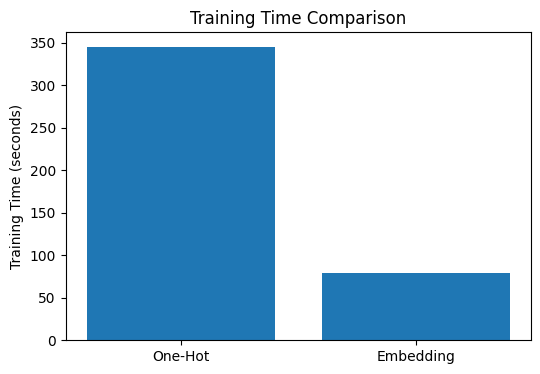

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(["One-Hot", "Embedding"], [onehot_time, embedding_time])
plt.ylabel("Training Time (seconds)")
plt.title("Training Time Comparison")
plt.show()

In [13]:
comparison_df = pd.DataFrame({
    "Method": ["One-Hot Encoding", "Trainable Embeddings"],
    "Final Loss": [onehot_losses[-1], embedding_losses[-1]],
    "Training Time (sec)": [onehot_time, embedding_time]
})
comparison_df

,Method,Final Loss,Training Time (sec)
0,One-Hot Encoding,7.225026,345.231007
1,Trainable Embeddings,7.391401,78.839811


**Observations:**
- **One-Hot:** Input dimension = vocab size; more parameters in first layer; often slower per epoch.
- **Embeddings:** Dense learned representations; typically faster per epoch and better scalability.